### Part 1 ‐ Exploratory data analysis

In [1]:
import json
from pandas.io.json import json_normalize
import pandas as pd
import re

In [2]:
data=json.load((open('logins.json')))

In [34]:
from datetime import datetime

logintimes =[ datetime.strptime(date,"%Y-%m-%d %H:%M:%S") for date in data['login_time']]   
df = pd.DataFrame(logintimes)
df.columns=['login_time']
df

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21
...,...
93137,1970-04-13 18:50:19
93138,1970-04-13 18:43:56
93139,1970-04-13 18:54:02
93140,1970-04-13 18:57:38


In [48]:

df['login_quarter'] = df['login_time'].apply(lambda dt: datetime(dt.year, dt.month, dt.day, dt.hour,15*(dt.minute // 15)))

In [62]:
quarterly_data= df.groupby('login_quarter')['login_time'].count().reset_index(name="count")

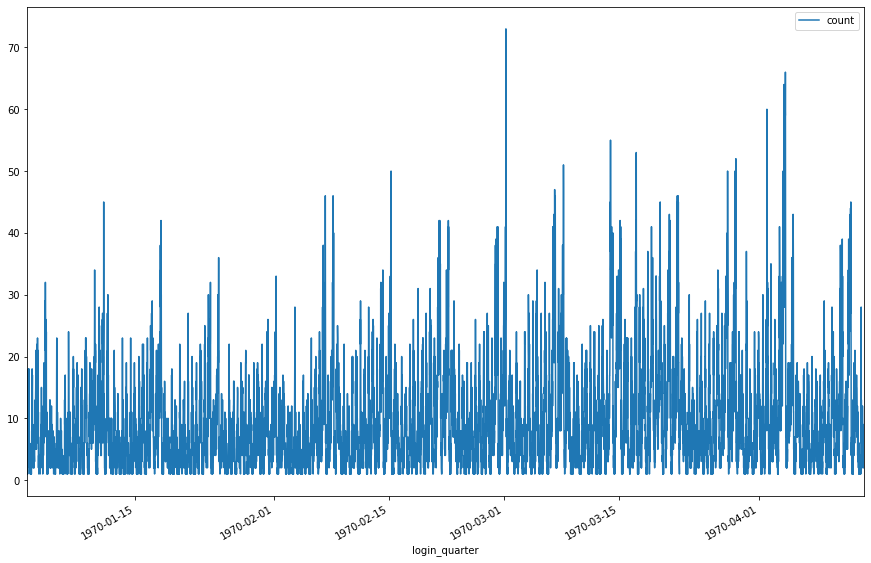

In [71]:
quarterly_data.plot(x='login_quarter', y='count',figsize=(15,10))

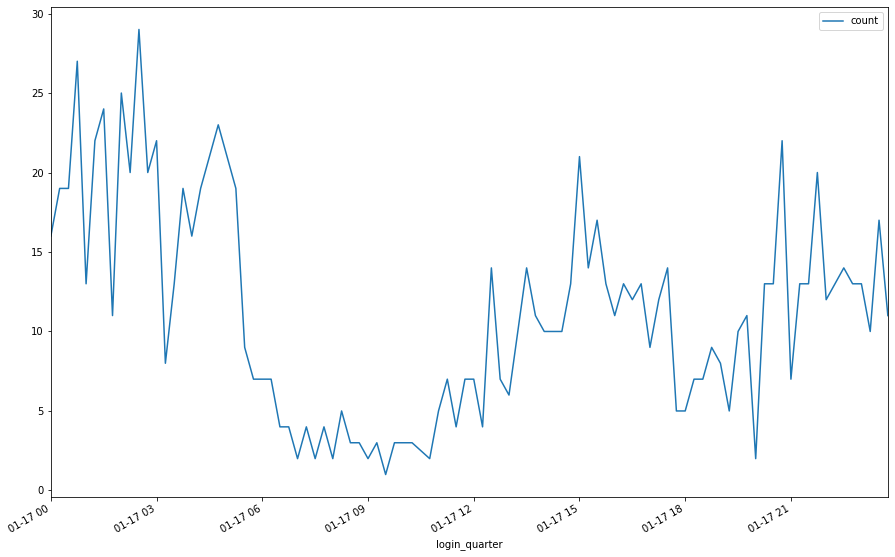

In [96]:
one_day = quarterly_data[quarterly_data['login_quarter'].dt.date == datetime.strptime('1970-01-17',"%Y-%m-%d").date()  ] 
one_day.plot(x='login_quarter', y='count',figsize=(15,10))

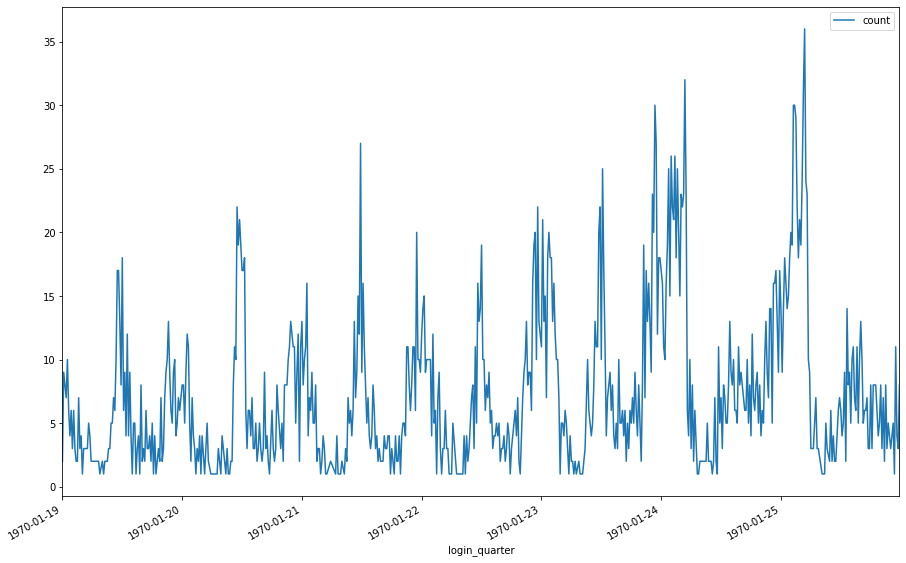

In [107]:
one_week = quarterly_data[quarterly_data['login_quarter'].dt.week == int(datetime.strptime('1970-01-23',"%Y-%m-%d").strftime("%V"))  ] 
one_week.plot(x='login_quarter', y='count',figsize=(15,10))

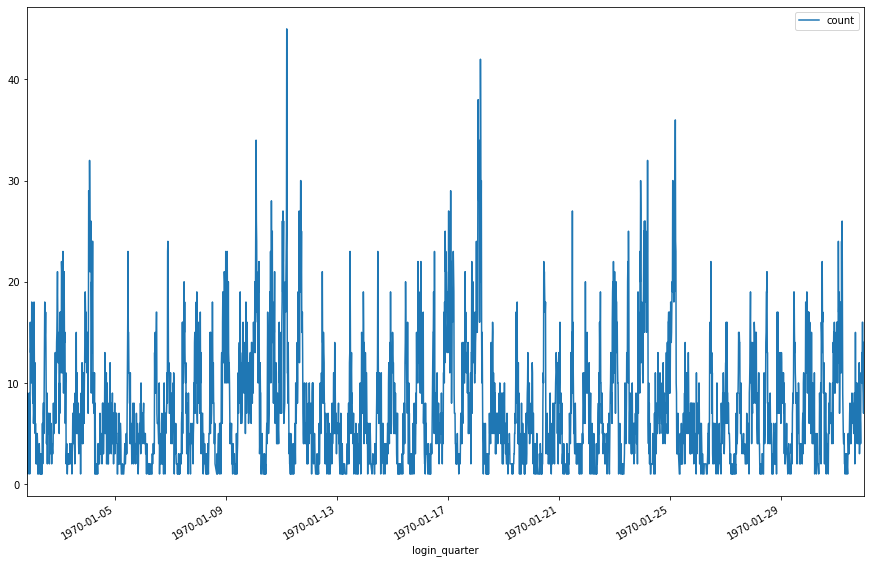

In [115]:
one_month= quarterly_data[quarterly_data['login_quarter'].dt.month == datetime.strptime('1970-01-1',"%Y-%m-%d").month  ] 
one_month.plot(x='login_quarter', y='count',figsize=(15,10))

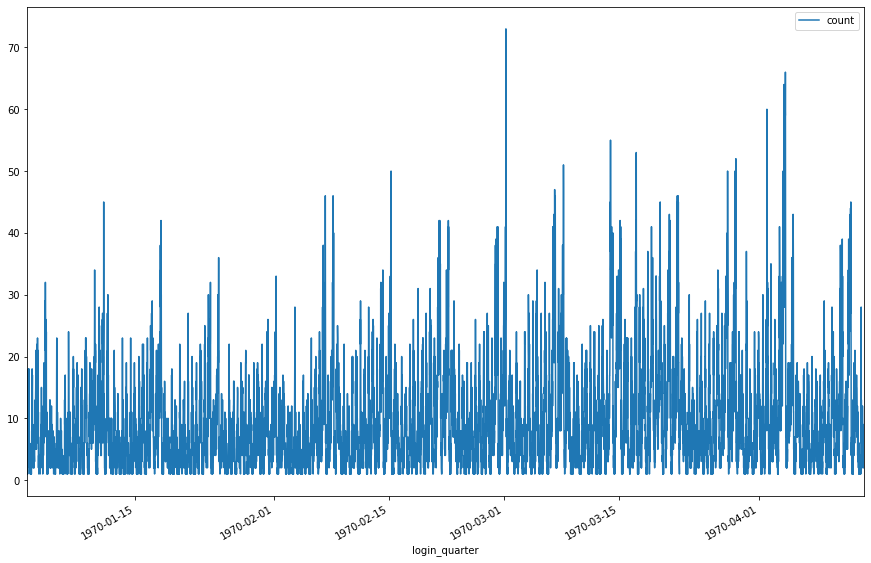

In [116]:
one_year= quarterly_data[quarterly_data['login_quarter'].dt.year == datetime.strptime('1970-01-1',"%Y-%m-%d").year  ] 
one_year.plot(x='login_quarter', y='count',figsize=(15,10))

### Part 2 ‐ Experiment and metrics design

We can simply collect the toll amount as a measuring metric, because it is direct reflection of driver crossing from city to city. 

Propose a experiment, only reimburse the tolls occured during week days not those during week ends and collect toll data for some amount of time (a month) before the expriment and during the experiment (a month) for both weekdays and weekend.  Then we simpley compare average daily tolls before and after using a Wald test for each day of the week (Sunday, Monday, ... Saturday). The null hypothesis is that there is no significant change for average daily tolls before and after on each week days and weekend days. If the change is effective we would expect to see week days daily toll can not be rejected and have a low p-value and for weekend days, we can not reject the null hypothesis and p-value will be high.




### Part 3 ‐ Predictive modeling

In [117]:
ultimate_data=json.load((open('ultimate_data_challenge.json')))

In [119]:
u_data= json_normalize(ultimate_data)


In [129]:
u_data.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [123]:
u_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
city                      50000 non-null object
trips_in_first_30_days    50000 non-null int64
signup_date               50000 non-null object
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
last_trip_date            50000 non-null object
phone                     49604 non-null object
surge_pct                 50000 non-null float64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [127]:
u_data.loc[u_data['avg_rating_of_driver'].isna()==True]


,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
6,Astapor,1,2014-01-24,NaN,1.0,2014-01-25,Android,0.0,False,100.0,3.95,4.0
9,Winterfell,1,2014-01-03,NaN,1.0,2014-01-05,Android,0.0,False,0.0,2.37,5.0
12,Winterfell,1,2014-01-15,NaN,1.0,2014-03-12,iPhone,0.0,False,100.0,20.29,5.0
14,Astapor,1,2014-01-27,NaN,1.0,2014-01-28,Android,0.0,False,100.0,26.01,5.0
15,Winterfell,1,2014-01-15,NaN,1.0,2014-01-16,Android,0.0,True,100.0,13.20,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...
49984,Winterfell,1,2014-01-26,NaN,1.0,2014-01-26,Android,0.0,False,0.0,3.50,5.0
49985,Astapor,1,2014-01-26,NaN,1.0,2014-02-25,Android,0.0,False,100.0,1.38,5.0
49989,Winterfell,1,2014-01-24,NaN,1.0,2014-01-31,iPhone,0.0,False,100.0,0.00,5.0
49996,Astapor,1,2014-01-24,NaN,1.0,2014-01-25,iPhone,0.0,False,0.0,0.00,4.0


In [133]:
u_data[u_data['avg_rating_of_driver'].isna()==True] = 0

In [131]:
u_data[u_data['avg_rating_by_driver'].isna()==True] = 0

In [132]:
u_data.loc[u_data['avg_rating_by_driver'].isna()==True]


,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver


In [138]:
u_data.loc[u_data['phone'].isna()==True]
u_data[u_data['phone'].isna()==True] = 'None'


,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
6,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,0
12,0,0,0,0,0,0,0,0,0,0,0,0
14,0,0,0,0,0,0,0,0,0,0,0,0
15,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
49984,0,0,0,0,0,0,0,0,0,0,0,0
49985,0,0,0,0,0,0,0,0,0,0,0,0
49989,0,0,0,0,0,0,0,0,0,0,0,0
49996,0,0,0,0,0,0,0,0,0,0,0,0


In [135]:
u_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
city                      50000 non-null object
trips_in_first_30_days    50000 non-null object
signup_date               50000 non-null object
avg_rating_of_driver      50000 non-null object
avg_surge                 50000 non-null object
last_trip_date            50000 non-null object
phone                     50000 non-null object
surge_pct                 50000 non-null object
ultimate_black_user       50000 non-null object
weekday_pct               50000 non-null object
avg_dist                  50000 non-null object
avg_rating_by_driver      50000 non-null object
dtypes: object(12)
memory usage: 4.6+ MB


In [137]:
u_data['phone'].unique()

array(['iPhone', 'Android', 0, 'None'], dtype=object)

In [143]:
#bad records
indexNames = u_data[u_data['phone']==0].index
u_data.drop(indexNames,inplace=True)

In [152]:
u_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41445 entries, 0 to 49998
Data columns (total 12 columns):
city                      41445 non-null object
trips_in_first_30_days    41445 non-null object
signup_date               41445 non-null object
avg_rating_of_driver      41445 non-null object
avg_surge                 41445 non-null object
last_trip_date            41445 non-null object
phone                     41445 non-null object
surge_pct                 41445 non-null object
ultimate_black_user       41445 non-null object
weekday_pct               41445 non-null object
avg_dist                  41445 non-null object
avg_rating_by_driver      41445 non-null object
dtypes: object(12)
memory usage: 4.1+ MB


In [151]:
u_data['city'].unique()
u_data.loc[u_data['city']=='None']
#turns out these records are bad records too, drop them.
indexcity = u_data[u_data['city']=='None'].index
u_data.drop(indexcity,inplace=True)
u_data['city'].unique()

array(["King's Landing", 'Astapor', 'Winterfell'], dtype=object)

In [163]:
#date fields conversion
u_data['signup_date']=u_data['signup_date'].astype('datetime64[ns]') 
u_data['last_trip_date']=u_data['last_trip_date'].astype('datetime64[ns]') 

In [171]:
#add an active days columns
u_data['active_days']=(u_data['last_trip_date'] - u_data['signup_date']).dt.days

In [187]:
#add retained column 
u_data['retained']=u_data['active_days'].apply(lambda x: 1 if x>=30 else 0)  


In [198]:

retained_percentage =  (u_data[u_data['retained']==1]['retained'].count()/u_data['retained'].count())
print("retained percentage: {:.2%}".format(retained_percentage))

retained percentage: 77.13%


In [188]:
u_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41445 entries, 0 to 49998
Data columns (total 14 columns):
city                      41445 non-null object
trips_in_first_30_days    41445 non-null object
signup_date               41445 non-null datetime64[ns]
avg_rating_of_driver      41445 non-null object
avg_surge                 41445 non-null object
last_trip_date            41445 non-null datetime64[ns]
phone                     41445 non-null object
surge_pct                 41445 non-null object
ultimate_black_user       41445 non-null object
weekday_pct               41445 non-null object
avg_dist                  41445 non-null object
avg_rating_by_driver      41445 non-null object
active_days               41445 non-null int64
retained                  41445 non-null int64
dtypes: datetime64[ns](2), int64(2), object(10)
memory usage: 4.7+ MB


In [184]:
u_data['last_trip_date'].dt.month.describe()

count    41445.000000
mean         4.208035
std          1.956384
min          1.000000
25%          2.000000
50%          5.000000
75%          6.000000
max          7.000000
Name: last_trip_date, dtype: float64

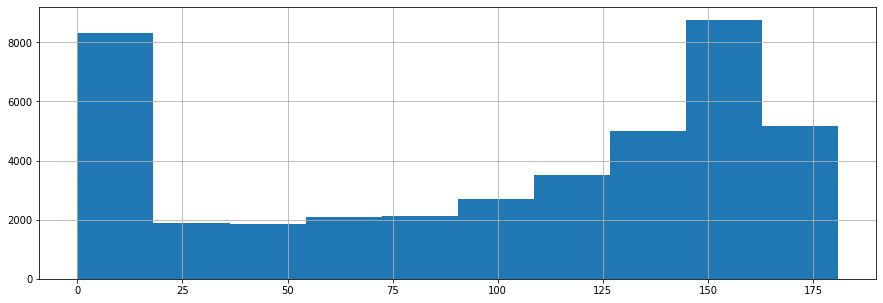

In [202]:
u_data['active_days'].hist(figsize=(15,5))

In [199]:
u_data.loc[u_data['active_days']>150].count()

# we should be able to say that if a customer is active beyond 150 days, then this is a 6th month active user.
# we can set a ground truth label, 6thmonthactive as following:
u_data['6thmonthactive']=u_data['active_days'].apply(lambda x: 1 if x>150 else 0)  

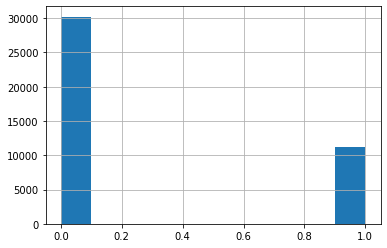

In [201]:
u_data['6thmonthactive'].hist()
#this is a quick way to show that our data is some what unbalanced (~3:1).  
#We need to take this into consideration when we create train and test split (stratify the data by target label)
#Also we need consider a metric to use to reflect better of the usefulness of our predictive model.  F1 Score?


In [242]:
#prep data for a predictive classfier (6th month active)
u_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41445 entries, 0 to 49998
Data columns (total 13 columns):
city                      41445 non-null int64
trips_in_first_30_days    41445 non-null int64
avg_rating_of_driver      41445 non-null float64
avg_surge                 41445 non-null float64
phone                     41445 non-null int64
surge_pct                 41445 non-null float64
ultimate_black_user       41445 non-null int64
weekday_pct               41445 non-null float64
avg_dist                  41445 non-null float64
avg_rating_by_driver      41445 non-null float64
active_days               41445 non-null int64
retained                  41445 non-null int64
6thmonthactive            41445 non-null int64
dtypes: float64(6), int64(7)
memory usage: 4.4 MB


In [241]:
u_data['city'].replace(["King's Landing", 'Astapor', 'Winterfell'],[0,1,2],inplace=True)
u_data['trips_in_first_30_days']=u_data['trips_in_first_30_days'].astype(int)
u_data.pop('signup_date')
u_data.pop('last_trip_date')
u_data['avg_rating_of_driver']=u_data['avg_rating_of_driver'].astype(float)
u_data['avg_surge']=u_data['avg_surge'].astype(float)
u_data['phone'].replace(['iPhone', 'Android'],[0,1],inplace=True)
u_data['surge_pct']=u_data['surge_pct'].astype(float)
u_data['ultimate_black_user']=u_data['ultimate_black_user'].astype(int)
u_data['weekday_pct']=u_data['weekday_pct'].astype(float)
u_data['avg_dist']=u_data['avg_dist'].astype(float)
u_data['avg_rating_by_driver']=u_data['avg_rating_by_driver'].astype(float)
 

array([5. , 4.9, 3. , 4.8, 4.7, 4.2, 4.5, 4. , 4.4, 4.6, 3.7, 4.3, 3.5,
       2. , 3.8, 2.5, 4.1, 3.9, 1. , 3.3, 3.4, 3.6, 3.2, 2.3, 2.8, 2.7,
       1.5])

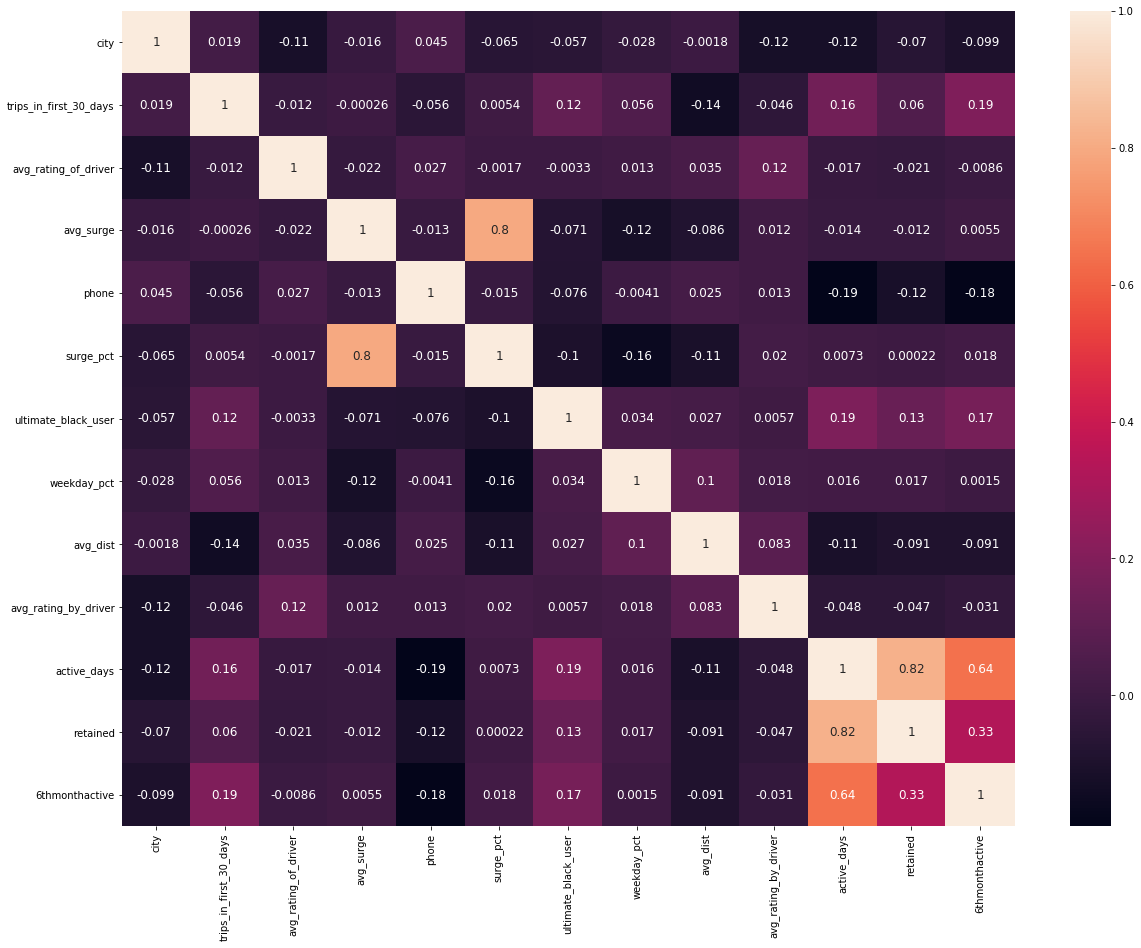

In [250]:
import seaborn as sns 
import matplotlib.pyplot as plt

corr = u_data.corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot = True, annot_kws={'size':12})
heat_map=plt.gcf()
heat_map.set_size_inches(20,15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

In [253]:
# as indicated in the correlation heat map, retained and active days as highly correlated. In fact retrain is derived from active days
# so for the classification task we will not use retained
# so is the avg_surge and surge_pct, will drop surge_pct
#u_data.pop('retained')
u_data.pop('surge_pct')

0        15.4
1         0.0
2         0.0
3        20.0
4        11.8
         ... 
49993    11.1
49994    37.5
49995     0.0
49997     0.0
49998     0.0
Name: surge_pct, Length: 41445, dtype: float64

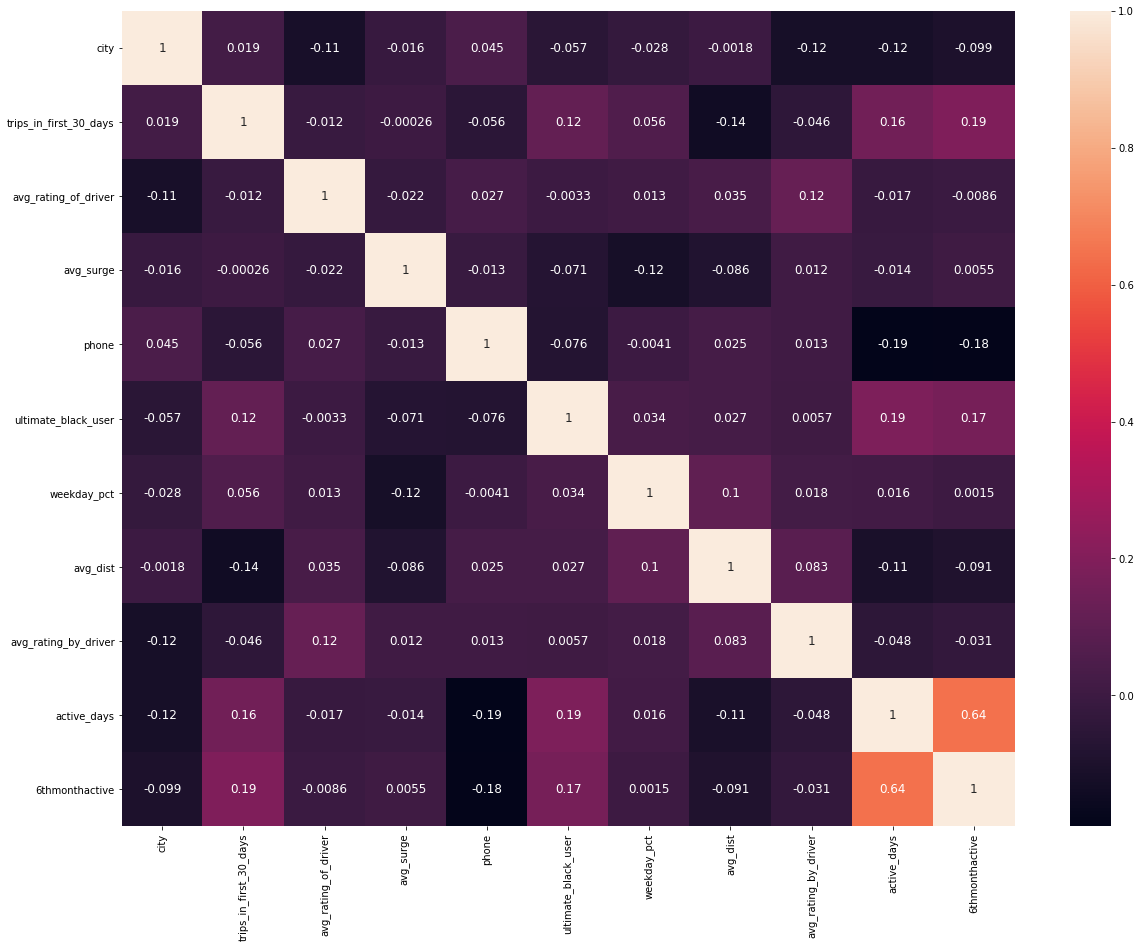

In [254]:
corr = u_data.corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot = True, annot_kws={'size':12})
heat_map=plt.gcf()
heat_map.set_size_inches(20,15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

In [260]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(u_data, test_size = 0.25)
 
train_y = train['6thmonthactive']
test_y = test['6thmonthactive']
 
train_x = train
train_x.pop('6thmonthactive')
test_x = test
test_x.pop('6thmonthactive')

7727     1
25906    0
2586     0
13985    1
46327    0
        ..
33161    0
40620    0
46732    0
38210    0
9364     1
Name: 6thmonthactive, Length: 10362, dtype: int64

In [262]:
test_x

,city,trips_in_first_30_days,avg_rating_of_driver,avg_surge,phone,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active_days
7727,0,1,4.7,1.16,0,0,54.2,2.27,4.8,169
25906,0,1,5.0,1.00,0,0,100.0,0.03,5.0,0
2586,2,7,5.0,1.25,0,1,100.0,2.40,4.4,133
13985,2,0,4.3,1.63,1,1,100.0,4.29,5.0,153
46327,1,1,5.0,1.15,1,1,40.0,3.92,4.8,113
...,...,...,...,...,...,...,...,...,...,...
33161,2,0,1.0,1.00,0,0,100.0,2.39,4.0,95
40620,2,0,2.5,1.00,0,0,100.0,5.89,5.0,92
46732,1,1,5.0,1.00,1,1,0.0,3.65,5.0,15
38210,2,2,4.8,1.00,0,0,50.0,2.82,4.4,139


Intercept: [-14.6750606]
Regression: [[-3.33775146e-01  4.89527693e-03 -8.65120404e-01 -9.56869173e+00
   1.15084756e-01 -1.25513673e-01 -1.00482395e-02 -4.19200754e-02
  -2.54899948e+00  2.81937708e-01]]
Accuracy of logistic regression classifier on test set: 0.96
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      7556
           1       0.91      0.94      0.93      2806

    accuracy                           0.96     10362
   macro avg       0.95      0.95      0.95     10362
weighted avg       0.96      0.96      0.96     10362



/Users/wweschen/ultimate_challenge/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Text(0.5, 15.0, 'Predicted label')

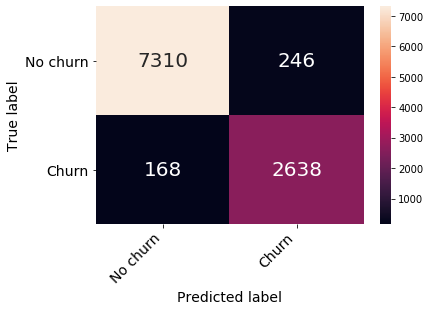

In [261]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

logisticRegr = LogisticRegression()
logisticRegr.fit(X=train_x, y=train_y)

test_y_pred = logisticRegr.predict(test_x)
confusion_matrix = confusion_matrix(test_y, test_y_pred)
print('Intercept: ' + str(logisticRegr.intercept_))
print('Regression: ' + str(logisticRegr.coef_))
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logisticRegr.score(test_x, test_y)))
print(classification_report(test_y, test_y_pred))

confusion_matrix_df = pd.DataFrame(confusion_matrix, ('No churn', 'Churn'), ('No churn', 'Churn'))
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={"size": 20}, fmt="d")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize = 14)
plt.ylabel('True label', fontsize = 14)
plt.xlabel('Predicted label', fontsize = 14)

In [263]:
#since active days are pretty much correlated to 6th month active user. If we want to predict 6 month ahead, 
# not from the 5th to predict 6th month, then we should drop the active days since we will not have it if we look 6 month into the future.
# also if we are developing a next month prediction, then we will need to create a different data feature such as time series for a customer
# like month one active, month 2 active, month 3 active etc.
u_data.pop('active_days')

0        143
1         96
2          1
3        170
4         47
        ... 
49993    179
49994    148
49995    131
49997    111
49998      1
Name: active_days, Length: 41445, dtype: int64

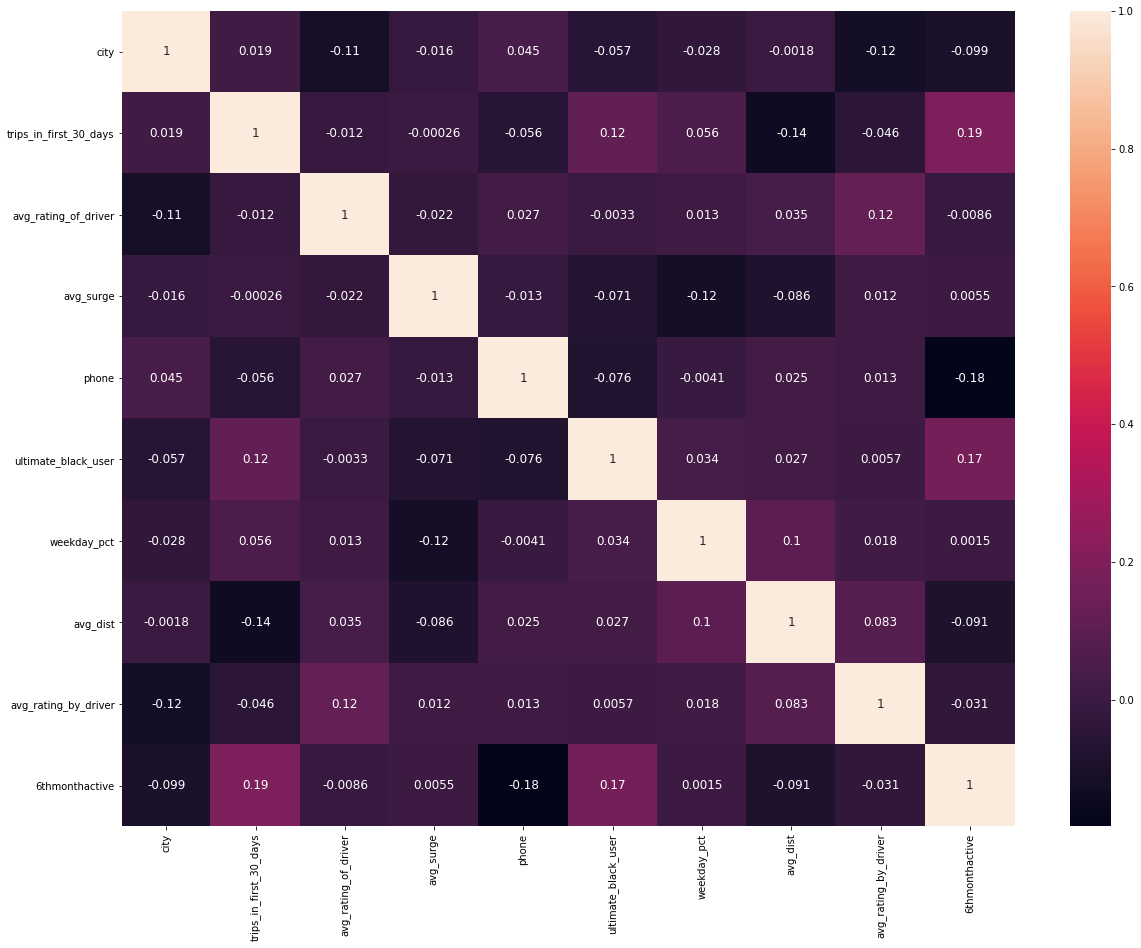

In [264]:
corr = u_data.corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot = True, annot_kws={'size':12})
heat_map=plt.gcf()
heat_map.set_size_inches(20,15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

In [265]:
train, test = train_test_split(u_data, test_size = 0.25)
 
train_y = train['6thmonthactive']
test_y = test['6thmonthactive']
 
train_x = train
train_x.pop('6thmonthactive')
test_x = test
test_x.pop('6thmonthactive')

20487    0
8751     0
33537    0
19202    1
116      0
        ..
9218     0
22919    1
40818    0
34411    1
32820    0
Name: 6thmonthactive, Length: 10362, dtype: int64

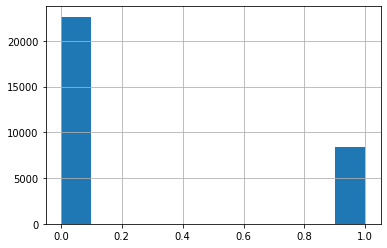

In [287]:
train_y.hist()

Intercept: [0.01847494]
Regression: [[-2.76730564e-01  9.18806013e-02 -2.48433991e-02  1.31501037e-01
  -9.83666503e-01  6.38922951e-01 -4.67456747e-04 -3.58004921e-02
  -1.62919099e-01]]
Accuracy of logistic regression classifier on test set: 0.74
              precision    recall  f1-score   support

           0       0.75      0.97      0.85      7572
           1       0.60      0.14      0.22      2790

    accuracy                           0.74     10362
   macro avg       0.67      0.55      0.53     10362
weighted avg       0.71      0.74      0.68     10362



/Users/wweschen/ultimate_challenge/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Text(0.5, 15.0, 'Predicted label')

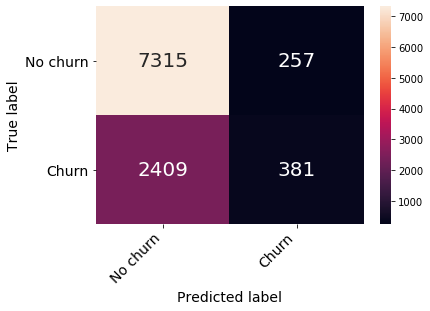

In [297]:
from sklearn.metrics import confusion_matrix
logisticRegr = LogisticRegression()
logisticRegr.fit(X=train_x, y=train_y)

test_y_pred = logisticRegr.predict(test_x)
 
confusion_matrix = confusion_matrix(test_y, test_y_pred)
print('Intercept: ' + str(logisticRegr.intercept_))
print('Regression: ' + str(logisticRegr.coef_))
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logisticRegr.score(test_x, test_y)))
print(classification_report(test_y, test_y_pred))

confusion_matrix_df = pd.DataFrame(confusion_matrix, ('No churn', 'Churn'), ('No churn', 'Churn'))
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={"size": 20}, fmt="d")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize = 14)
plt.ylabel('True label', fontsize = 14)
plt.xlabel('Predicted label', fontsize = 14)

In [300]:
from sklearn.ensemble import RandomForestClassifier
randomForest = RandomForestClassifier()
randomForest.fit(train_x, train_y)
print('Accuracy of random forest classifier on test set: {:.2f}'.format(randomForest.score(test_x, test_y)))

Accuracy of random forest classifier on test set: 0.75


In [299]:
u_data['6thmonthactive'].value_counts()

0    30209
1    11236
Name: 6thmonthactive, dtype: int64

In [278]:
from sklearn.utils import resample
 
data_majority = u_data[u_data['6thmonthactive']==0]
data_minority = u_data[u_data['6thmonthactive']==1]
 
data_minority_upsampled = resample(data_minority,
replace=True,
n_samples=30209, #same number of samples as majority classe
random_state=1) #set the seed for random resampling
# Combine resampled results
data_upsampled = pd.concat([data_majority, data_minority_upsampled])
 
data_upsampled['6thmonthactive'].value_counts()

1    30209
0    30209
Name: 6thmonthactive, dtype: int64

In [298]:
train, test = train_test_split(data_upsampled, test_size = 0.25)
 
train_y_upsampled = train['6thmonthactive']
test_y_upsampled = test['6thmonthactive']
 
train_x_upsampled = train
train_x_upsampled.pop('6thmonthactive')
test_x_upsampled = test
test_x_upsampled.pop('6thmonthactive')
 
logisticRegr_balanced = LogisticRegression()
logisticRegr_balanced.fit(X=train_x_upsampled, y=train_y_upsampled)
 
test_y_pred_balanced = logisticRegr_balanced.predict(test_x_upsampled)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logisticRegr_balanced.score(test_x_upsampled, test_y_upsampled)))
print(classification_report(test_y_upsampled, test_y_pred_balanced))

Accuracy of logistic regression classifier on test set: 0.65
              precision    recall  f1-score   support

           0       0.65      0.66      0.65      7616
           1       0.65      0.64      0.64      7489

    accuracy                           0.65     15105
   macro avg       0.65      0.65      0.65     15105
weighted avg       0.65      0.65      0.65     15105



/Users/wweschen/ultimate_challenge/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [283]:
from sklearn.metrics import roc_auc_score
 
# Get class probabilities for both models
test_y_prob = logisticRegr.predict_proba(test_x)
test_y_prob_balanced = logisticRegr_balanced.predict_proba(test_x_upsampled)
 
# We only need the probabilities for the positive class
test_y_prob = [p[1] for p in test_y_prob]
test_y_prob_balanced = [p[1] for p in test_y_prob_balanced]
 
print('Unbalanced model AUROC: ' + str(roc_auc_score(test_y, test_y_prob)))
print('Balanced model AUROC: ' + str(roc_auc_score(test_y_upsampled, test_y_prob_balanced)))

Unbalanced model AUROC: 0.7014751338169107
Balanced model AUROC: 0.7031633539980846


Accuracy of random forest classifier on test set: 0.87
              precision    recall  f1-score   support

           0       0.94      0.79      0.86      7616
           1       0.82      0.95      0.88      7489

    accuracy                           0.87     15105
   macro avg       0.88      0.87      0.87     15105
weighted avg       0.88      0.87      0.87     15105



Text(0.5, 15.0, 'Predicted label')

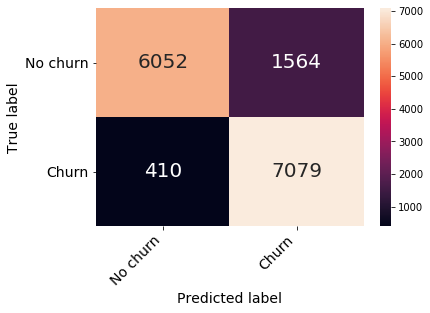

In [301]:
from sklearn.ensemble import RandomForestClassifier
randomForest = RandomForestClassifier()
randomForest.fit(train_x_upsampled, train_y_upsampled)

test_y_pred_balanced = randomForest.predict(test_x_upsampled)

print('Accuracy of random forest classifier on test set: {:.2f}'.format(randomForest.score(test_x_upsampled, test_y_upsampled)))
print(classification_report(test_y_upsampled, test_y_pred_balanced))

from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(test_y_upsampled, test_y_pred_balanced)
confusion_matrix_df = pd.DataFrame(confusion_matrix, ('No churn', 'Churn'), ('No churn', 'Churn'))
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={"size": 20}, fmt="d")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize = 14)
plt.ylabel('True label', fontsize = 14)
plt.xlabel('Predicted label', fontsize = 14)



In [308]:
imp =[]
for name, importance in zip(train_x_upsampled.columns, randomForest.feature_importances_):
    print(name, "=", importance)
    imp.append([name,importance])

city = 0.058720471637289204
trips_in_first_30_days = 0.0922740385795199
avg_rating_of_driver = 0.09102895834781463
avg_surge = 0.10948313861020591
phone = 0.030856481575113618
ultimate_black_user = 0.02514811821899092
weekday_pct = 0.16550528949261384
avg_dist = 0.30200198477874085
avg_rating_by_driver = 0.12498151875971125


In [322]:
def Sort(sub_li,reverse):
    return(sorted(sub_li, reverse=reverse,key = lambda x: x[1]))    

sorted_importance = Sort(imp,True)
print(Sort(imp,True))

for x in sorted_importance:
    print(x[0],x[1])
    

[['avg_dist', 0.30200198477874085], ['weekday_pct', 0.16550528949261384], ['avg_rating_by_driver', 0.12498151875971125], ['avg_surge', 0.10948313861020591], ['trips_in_first_30_days', 0.0922740385795199], ['avg_rating_of_driver', 0.09102895834781463], ['city', 0.058720471637289204], ['phone', 0.030856481575113618], ['ultimate_black_user', 0.02514811821899092]]
avg_dist 0.30200198477874085
weekday_pct 0.16550528949261384
avg_rating_by_driver 0.12498151875971125
avg_surge 0.10948313861020591
trips_in_first_30_days 0.0922740385795199
avg_rating_of_driver 0.09102895834781463
city 0.058720471637289204
phone 0.030856481575113618
ultimate_black_user 0.02514811821899092


In [306]:
train_x_upsampled.columns

Index(['city', 'trips_in_first_30_days', 'avg_rating_of_driver', 'avg_surge',
       'phone', 'ultimate_black_user', 'weekday_pct', 'avg_dist',
       'avg_rating_by_driver'],
      dtype='object')

In [304]:
from sklearn import tree
from sklearn import tree
import graphviz 
 
# Create each decision tree (pruned and unpruned)
decisionTree_unpruned = tree.DecisionTreeClassifier()
decisionTree = tree.DecisionTreeClassifier(max_depth = 4)
 
# Fit each tree to our training data
decisionTree_unpruned = decisionTree_unpruned.fit(X=train_x_upsampled, y=train_y_upsampled)
decisionTree = decisionTree.fit(X=train_x_upsampled, y=train_y_upsampled)
 
# Generate PDF visual of decision tree
churnTree = tree.export_graphviz(decisionTree, out_file=None, 
                         feature_names = list(train_x_upsampled.columns.values),  
                         class_names = ['No churn', 'Churn'],
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(churnTree)
graph.render('decision_tree.gv', view=True)

'decision_tree.gv.pdf'

### Result Analysis

1. We defined this problem as a classification problem.
2. It is a unbalanced dataset (3:1)
3. Tried Logistic regression and Random Forest algorithm
4. Random Forest on up-sampled dataset gives the best result (accuracy 87%)
5. Strange thing is that with up-sampled dataset, logistic regression actually give worse result than that using unbalanced dataset directly.
6. Feature importance ranking:
    * avg_dist 0.30200198477874085
    * weekday_pct 0.16550528949261384
    * avg_rating_by_driver 0.12498151875971125
    * avg_surge 0.10948313861020591
    * trips_in_first_30_days 0.0922740385795199
    * avg_rating_of_driver 0.09102895834781463
    * city 0.058720471637289204
    * phone 0.030856481575113618
    * ultimate_black_user 0.02514811821899092
7. analysis:
    * The distance seems to the main concern when using this ride service.
    * Work related needs are also important.
    * Driver's attitude seems affect the ridership.
    * Early adopters seem to be more likely to stick around.
8. Improvement suggestions to City Operator:
    * Improve the driver training for better customer service
    * Plan the ride service focusing more on the most needed population